<a href="https://colab.research.google.com/github/annsam0115/CIND820/blob/main/CIND820_CapstoneProject_ASAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries:

In [152]:
import pandas as pd 
import numpy as np 
import plotly
import matplotlib.pyplot as plt 
import seaborn as sns 

import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#Data Preparation:

In [153]:
from google.colab import files
uploaded = files.upload()

Saving water_potability.csv to water_potability (2).csv


In [154]:
data = pd.read_csv("water_potability.csv")
df = pd.DataFrame(data)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
df.shape

(3276, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.nunique()

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64

In [ ]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

There is an imbalance of data for the target variable. Non poptable samples have been oversampled versus the potatble samples.

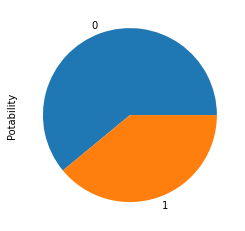

In [ ]:
df.Potability.value_counts().plot(kind ='pie')

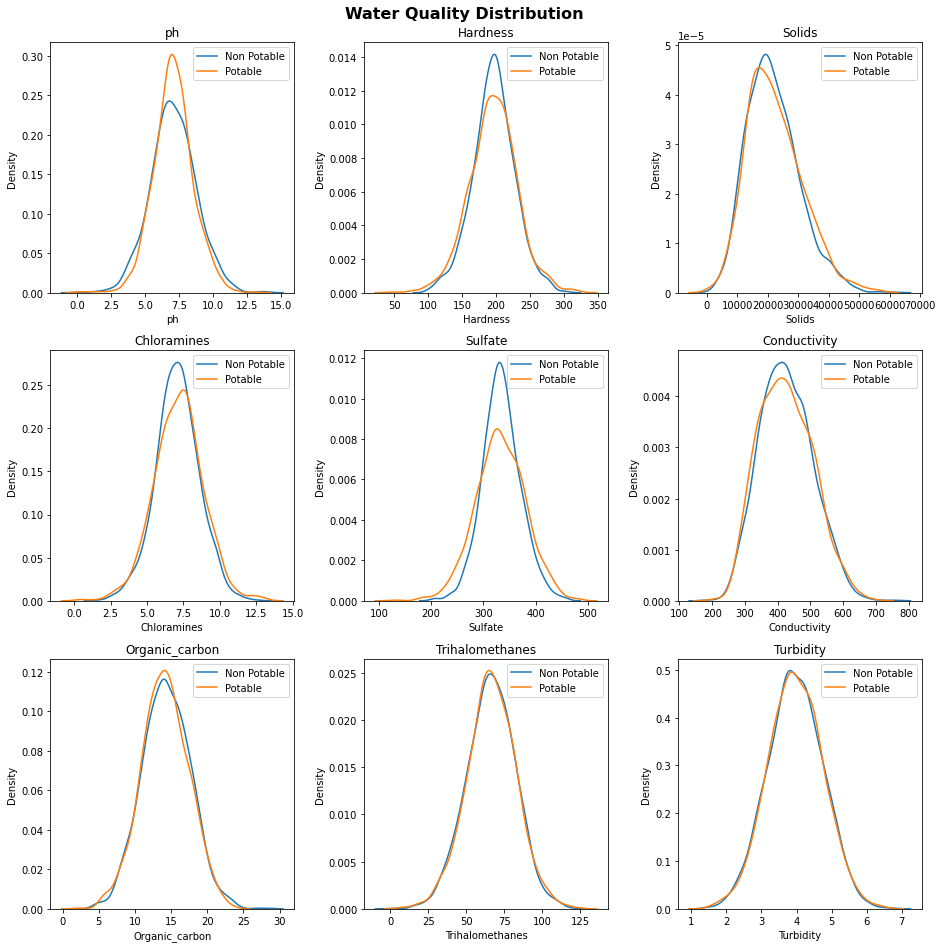

In [ ]:
non_potable = df[df['Potability'] == 0]
potable = df[df['Potability'] == 1]

plt.figure(figsize=(13,13))

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(col)
    sns.kdeplot(x=non_potable[col],label = "Non Potable")
    sns.kdeplot(x=potable[col],label = "Potable")
    plt.legend()

plt.suptitle('Water Quality Distribution',y=1.01, size = 16, color = 'black', weight='bold')   
plt.tight_layout()

In [ ]:
df.drop('Potability', axis=1).skew()

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

Distirbution of the data is mostly Gaussian.

In [ ]:
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


Text(0.5, 0.92, 'Water Quality Heat Map')

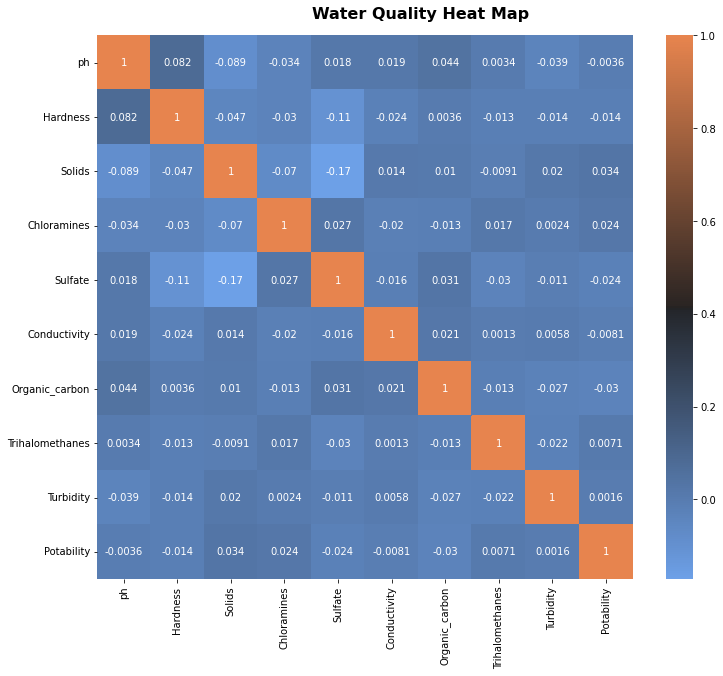

In [ ]:
plt.figure(figsize = (12,10))
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(df.corr(), annot = True, cmap=cmap)
plt.suptitle('Water Quality Heat Map', y = 0.92, size = 16, color = 'black', weight='bold')

In [ ]:
df.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Solids             0.033743
Organic_carbon     0.030001
Chloramines        0.023779
Sulfate            0.023577
Hardness           0.013837
Conductivity       0.008128
Trihalomethanes    0.007130
ph                 0.003556
Turbidity          0.001581
Name: Potability, dtype: float64

Text(0.5, 1.01, 'Water Quality Pair-Plot')

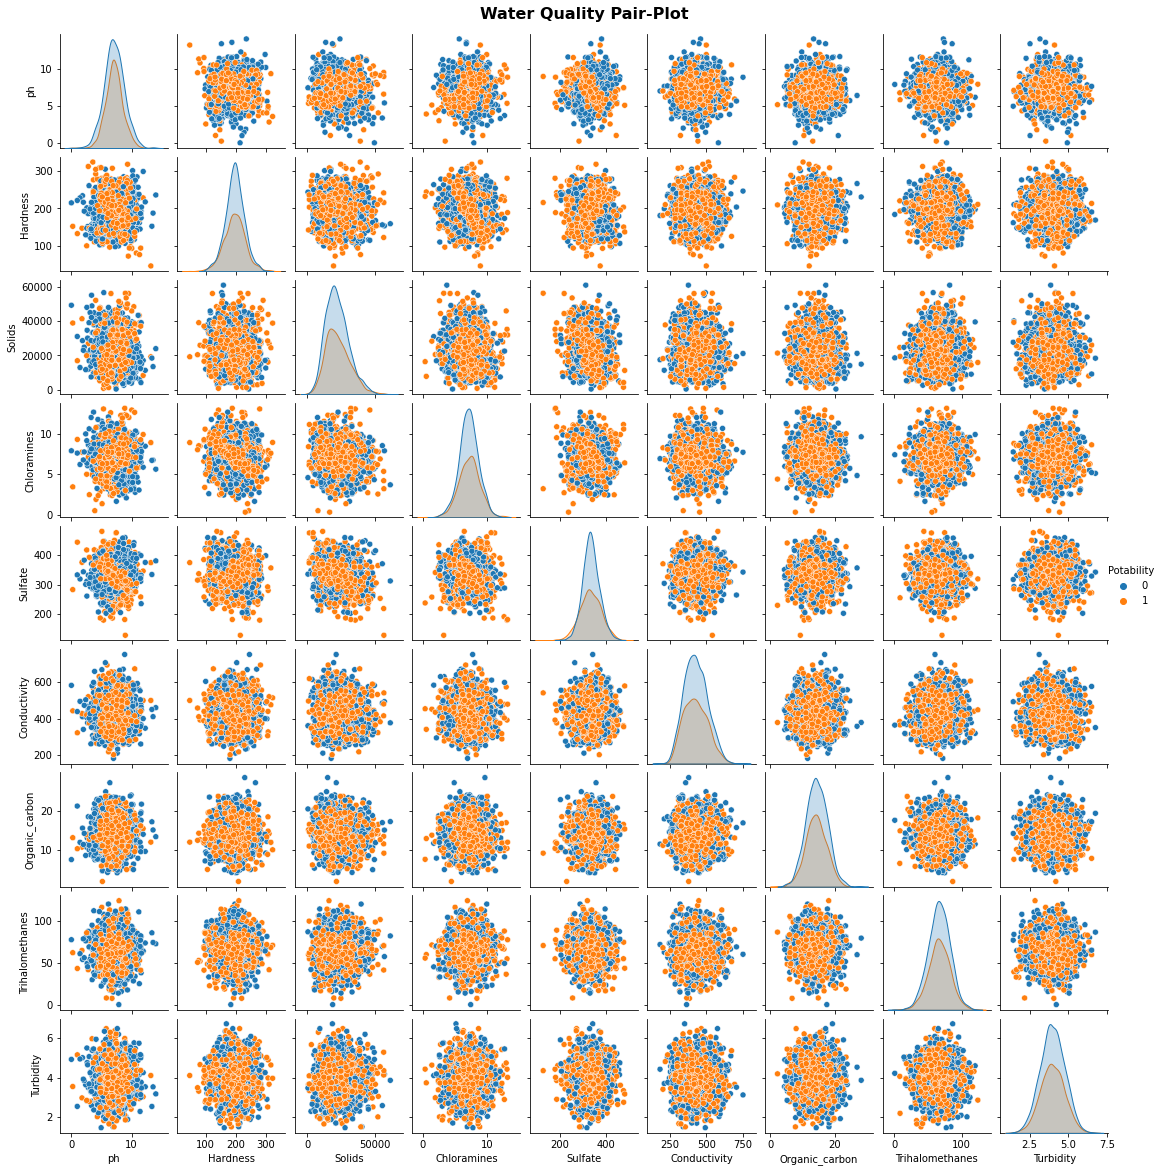

In [ ]:
ax = sns.pairplot(df, hue = "Potability", diag_kind = "kde", kind = "scatter")
ax.fig.set_size_inches(16,16)
ax.fig.suptitle('Water Quality Pair-Plot',y=1.01, size = 16, color = 'black', weight='bold')

Both the correlation heatmap and pairplots between the variables show that there are no clear linear relationships between the features and the target variable. We can rule out using a simple linear model.

Text(0.5, 1.01, 'Water Quality Box-Plot')

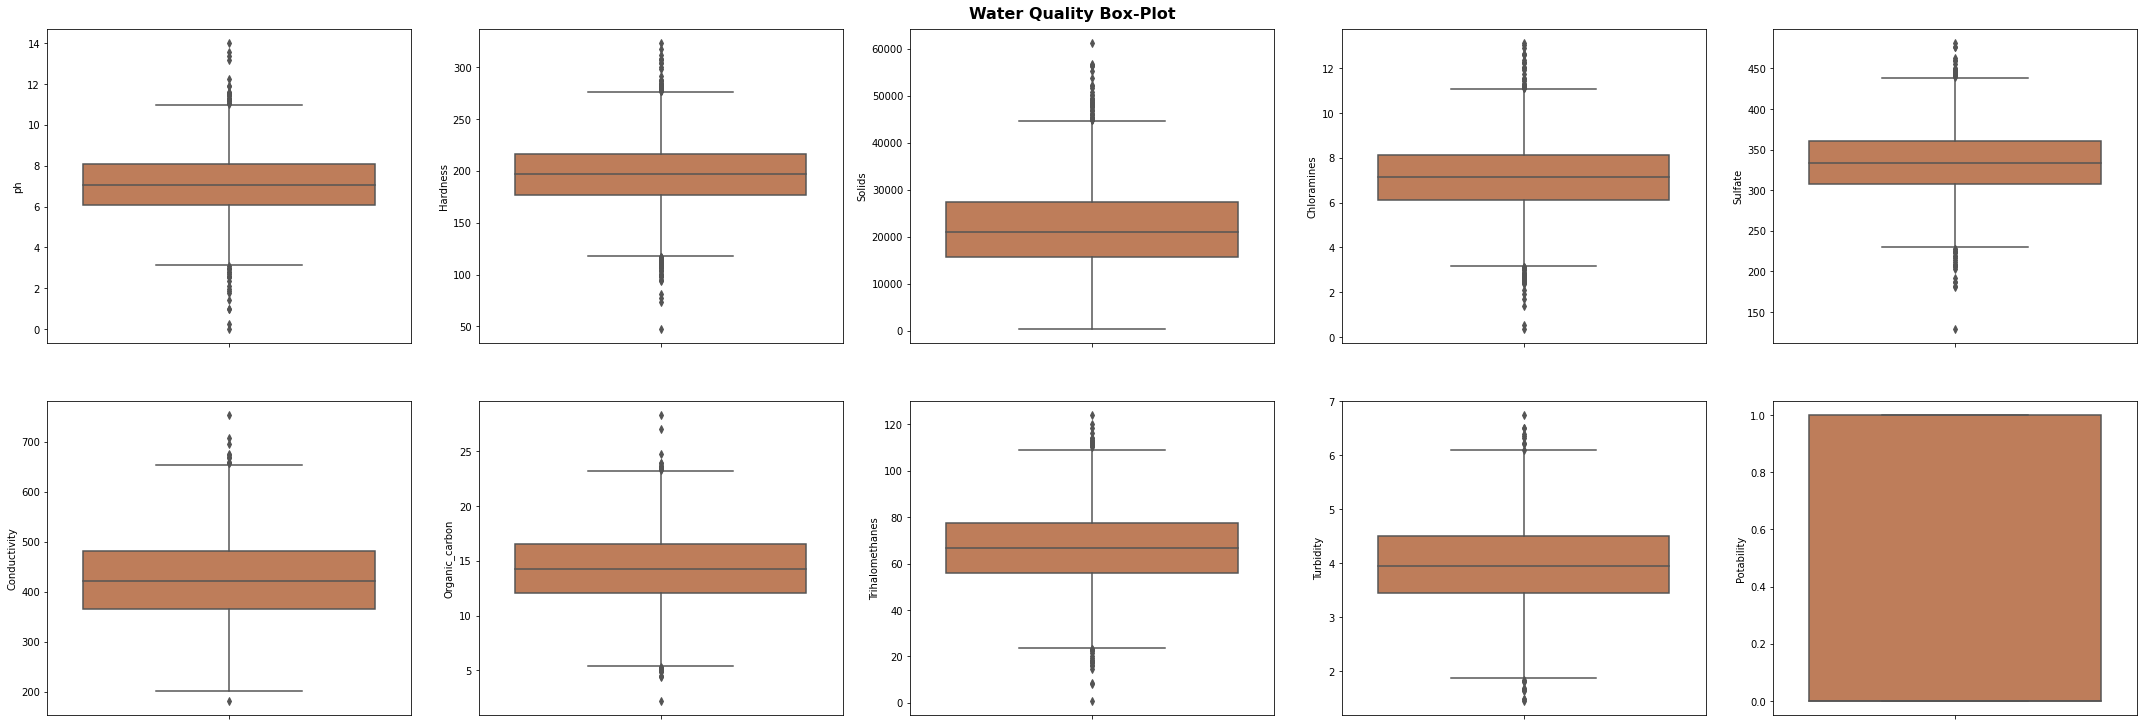

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(30,10))
index = 0
ax = ax.flatten()

for attributeCol, value in df.items():
    sns.boxplot(y=attributeCol, data=df, ax=ax[index], color="#cf7849")
    index += 1
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=5.0)

plt.suptitle('Water Quality Box-Plot',y=1.01, size = 16, color = 'black', weight='bold')

There are outliers within every feature of the dataset.

#Dealing with Missing Values

In [ ]:
df.isna().any().any()

True

In [ ]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
df.isnull().mean()*100 

ph                 14.164164
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            22.872873
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.879880
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [ ]:
df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()

ph                   7.085378
Sulfate            334.564290
Trihalomethanes     66.303555
dtype: float64

In [ ]:
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()

ph                   7.073783
Sulfate            332.566990
Trihalomethanes     66.539684
dtype: float64

The three features with missing values all have Gaussian distribution therefore it is a safe assumption to use the mean of each feature to fill in for the missing values.

In [155]:
df1 = df.copy()
df1['ph'].fillna(value=df1['ph'].mean(),inplace=True)
df1['Sulfate'].fillna(value=df1['Sulfate'].mean(),inplace=True)
df1['Trihalomethanes'].fillna(value=df1['Trihalomethanes'].mean(),inplace=True)

In [156]:
df1.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

#Dealing with Outliers

Since the features have Gaussian distribution we can trim out the outliers data outside of 3 standard deviations.

In [157]:
from scipy import stats

df_water = df1.copy()
df_water = df_water[(np.abs(stats.zscore(df1)) <= 3).all(axis=1)]

In [158]:
df_water.shape

(3128, 10)

Text(0.5, 1.01, 'Water Quality Box-Plot (after outlier trimming)')

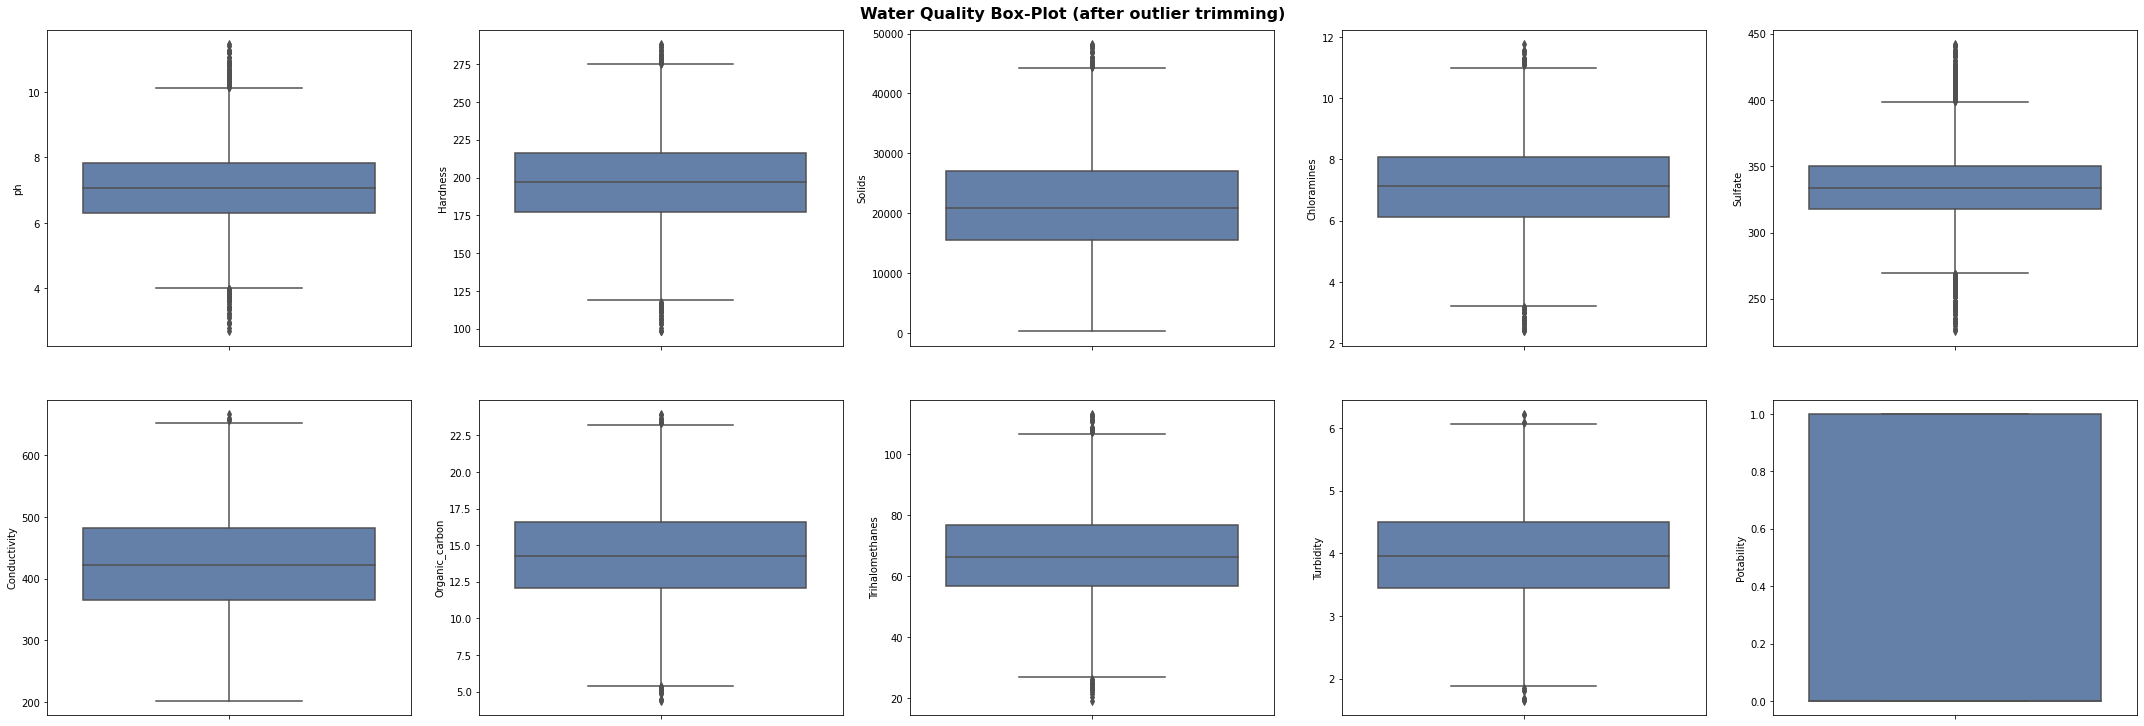

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(30,10))
index = 0
ax = ax.flatten()

for attributeCol, value in df_water.items():
    sns.boxplot(y=attributeCol, data=df_water, ax=ax[index], color='#597eb3')
    index += 1
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=5.0)
plt.suptitle('Water Quality Box-Plot (after outlier trimming)',y=1.01, size = 16, color = 'black', weight='bold')

#Dealing with Class Imbalance

In [159]:
df_water_trim = df_water.copy()

In [160]:
df_water_trim['Potability'].value_counts()

0    1930
1    1198
Name: Potability, dtype: int64

In [161]:
zero  = df_water_trim[df_water_trim['Potability']==0]   #oversampled
one = df_water_trim[df_water_trim['Potability']==1]  #undersampled

from sklearn.utils import resample
one_balanced = resample(one, replace = True, n_samples = 1930, random_state=0) 

df_water_trim = pd.concat([zero, one_balanced])

In [162]:
df_water_trim['Potability'].value_counts()

0    1930
1    1930
Name: Potability, dtype: int64

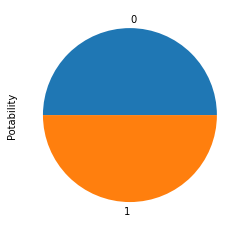

In [ ]:
df_water_trim.Potability.value_counts().plot(kind ='pie')

In [ ]:
df_water_trim.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000,3860.000000
mean,7.083442,196.427507,21696.204613,7.123426,333.470588,426.697787,14.267547,66.356328,3.971197,0.500000
std,1.345287,31.803023,8418.873637,1.544071,34.828250,81.039408,3.262177,15.257816,0.781653,0.500065
min,2.690831,98.367915,320.942611,2.456014,225.516628,201.619737,4.371899,19.175175,1.641515,0.000000
25%,6.312309,177.340311,15421.148879,6.110295,316.537403,365.013500,12.125679,56.797794,3.439022,0.000000
50%,7.080795,196.901673,20522.302569,7.130161,333.775777,423.312186,14.197604,66.396293,3.963487,0.500000
75%,7.817995,216.612475,27117.762433,8.105680,350.397082,483.323463,16.519916,76.423373,4.504922,1.000000
max,11.449739,287.975540,48175.852093,11.753904,441.826777,666.690618,23.952450,113.048886,6.226580,1.000000


In [ ]:
df_water_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3860 entries, 0 to 3235
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3860 non-null   float64
 1   Hardness         3860 non-null   float64
 2   Solids           3860 non-null   float64
 3   Chloramines      3860 non-null   float64
 4   Sulfate          3860 non-null   float64
 5   Conductivity     3860 non-null   float64
 6   Organic_carbon   3860 non-null   float64
 7   Trihalomethanes  3860 non-null   float64
 8   Turbidity        3860 non-null   float64
 9   Potability       3860 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 460.8 KB


#Exploring correlation using ANOVA

In [163]:
def FunctionAnova(inpData, TargetVariable, attributeList):
    from scipy.stats import f_oneway

    SelectedPredictors=[]
    
    for predictor in attributeList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If p-value <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, ', P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, ', P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [164]:
attributeColList = ['ph',	'Hardness',	'Solids',	'Chloramines',	'Sulfate',	'Conductivity',	'Organic_carbon',	'Trihalomethanes',	'Turbidity']

FunctionAnova(inpData=df_water_trim, TargetVariable='Potability', attributeList=attributeColList)

ph is NOT correlated with Potability , P-Value: 0.8657065267599532
Hardness is NOT correlated with Potability , P-Value: 0.739360475437647
Solids is NOT correlated with Potability , P-Value: 0.7396602629907003
Chloramines is NOT correlated with Potability , P-Value: 0.18338940464053585
Sulfate is NOT correlated with Potability , P-Value: 0.17142973698372493
Conductivity is NOT correlated with Potability , P-Value: 0.7674916501214136
Organic_carbon is NOT correlated with Potability , P-Value: 0.12325509072862226
Trihalomethanes is NOT correlated with Potability , P-Value: 0.93967064771414
Turbidity is NOT correlated with Potability , P-Value: 0.47192199682536307


[]

ANOVA testing determine that there not any features that correlate with the target variable Potability with an acceptable P-Value.

#Exploring dimensionalty reduction using PCA:

In [ ]:
from sklearn.model_selection import train_test_split

X = df_water_trim.drop('Potability',axis=1)
y = df_water_trim['Potability']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

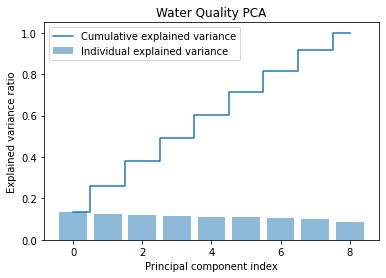

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

pca = PCA()

X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Water Quality PCA")
plt.legend(loc='best')
plt.show()

PCA tells us that all the features are independent and confirm our previous observations from the correlation matrix and heatmap that there are not linear relationships between the features. This PCA analysis of explained variance ratio tells us that we would still need 8 components to explain 90% of the variance. Therefore, dimensionality reduction will not be beneficial with this dataset.

#Preprocessing: Train-test split and standardized scaler

In [165]:
from sklearn.model_selection import train_test_split

X = df_water_trim.drop('Potability',axis=1)
y = df_water_trim['Potability']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale = StandardScaler()
X_train=scale.fit_transform(X_train)
X_test=scale.transform(X_test)

In [166]:
print("X_train:", X_train.shape, "\ny_train:", y_train.shape)
print("X_test:", X_test.shape, "\ny_test:", y_test.shape)

X_train: (3088, 9) 
y_train: (3088,)
X_test: (772, 9) 
y_test: (772,)


#Hyper-tunning parameters

In [167]:
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [168]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC()
xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

In [ ]:
para_knn = {'n_neighbors':np.arange(1, 50)}
grid_knn = GridSearchCV(knn, param_grid=para_knn, cv=5)
grid_knn.fit(X_train, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)

Best parameters for KNN: {'n_neighbors': 1}


In [ ]:
para_dt = {'criterion':['gini','entropy'],'max_depth':np.arange(1, 50), 'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}
grid_dt = GridSearchCV(dt, param_grid=para_dt, cv=5) 
grid_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 34, 'min_samples_leaf': 1}


In [ ]:
params_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 500}


In [ ]:
para_svc = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_svc = GridSearchCV(svc, param_grid=para_svc, cv=5)
grid_svc.fit(X_train, y_train)
print("Best parameters for SVM:", grid_svc.best_params_)

Best parameters for SVM: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)
rs_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

Best parameters for XGBoost: {'n_estimators': 800, 'learning_rate': 0.5}


#Predictive Modeling/Classication:

#1. Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
LogReg_pred = LogReg.predict(X_test)
LogReg_acc = accuracy_score(y_test, LogReg_pred)
LogReg_mae = mean_absolute_error(y_test, LogReg_pred)
LogReg_mse = mean_squared_error(y_test, LogReg_pred)
LogReg_rmse = np.sqrt(mean_squared_error(y_test, LogReg_pred))
LogReg_precision = precision_score(y_test, LogReg_pred)
LogReg_recall = recall_score(y_test, LogReg_pred)
LogReg_f1 = f1_score(y_test, LogReg_pred)

In [ ]:
print("The accuracy for Logistic Regression is", LogReg_acc)
print("The classification report using Logistic Regression is:")
print(classification_report(y_test, LogReg_pred))

The accuracy for Logistic Regression is 0.4676165803108808
The classification report using Logistic Regression is:
              precision    recall  f1-score   support

           0       0.48      0.40      0.44       400
           1       0.46      0.54      0.49       372

    accuracy                           0.47       772
   macro avg       0.47      0.47      0.47       772
weighted avg       0.47      0.47      0.47       772



Text(0.5, 1.0, 'Logisitic Regression Confusion Matrix')

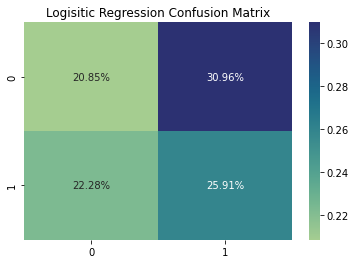

In [ ]:
LogReg_cm = confusion_matrix(y_test, LogReg_pred)
sns.heatmap(LogReg_cm/np.sum(LogReg_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("Logisitic Regression Confusion Matrix")

#2. K-Nearest Neighbour Regression

In [170]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 1)
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_test)
KNN_acc = accuracy_score(y_test, KNN_pred)
KNN_mae = mean_absolute_error(y_test, KNN_pred)
KNN_mse = mean_squared_error(y_test, KNN_pred)
KNN_rmse = np.sqrt(mean_squared_error(y_test, KNN_pred))
KNN_precision = precision_score(y_test, KNN_pred) 
KNN_recall = recall_score(y_test, KNN_pred) 
KNN_f1 = f1_score(y_test, KNN_pred)

In [ ]:
print("The accuracy for KNeighbors is", KNN_acc)
print("The classification report using KNeighbors is:", KNN_acc)
print(classification_report(y_test, KNN_pred))

The accuracy for KNeighbors is 0.7746113989637305
The classification report using KNeighbors is: 0.7746113989637305
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       400
           1       0.72      0.86      0.79       372

    accuracy                           0.77       772
   macro avg       0.78      0.78      0.77       772
weighted avg       0.78      0.77      0.77       772



Text(0.5, 1.0, 'KNN Regression Confusion Matrix')

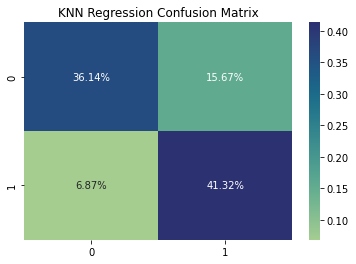

In [ ]:
KNN_cm = confusion_matrix(y_test, KNN_pred)
sns.heatmap(KNN_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("KNN Regression Confusion Matrix")

#3. Decision Tree Classifier

In [171]:
from sklearn.tree import DecisionTreeClassifier

DecTree = DecisionTreeClassifier(max_depth = 34, min_samples_leaf = 1, criterion ='entropy')
DecTree.fit(X_train, y_train)
DecTree_pred = DecTree.predict(X_test)
DecTree_acc = accuracy_score(y_test, DecTree_pred)
DecTree_precision = precision_score(y_test, DecTree_pred) 
DecTree_recall = recall_score(y_test, DecTree_pred) 
DecTree_f1 = f1_score(y_test, DecTree_pred)

In [ ]:
print("The accuracy for Decision Tree is", DecTree_acc)
print("The classification report using Decision Tree is:")
print(classification_report(y_test, DecTree_pred))

The accuracy for Decision Tree is 0.7616580310880829
The classification report using Decision Tree is:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       400
           1       0.71      0.84      0.77       372

    accuracy                           0.76       772
   macro avg       0.77      0.76      0.76       772
weighted avg       0.77      0.76      0.76       772



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

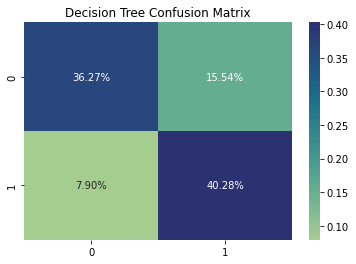

In [ ]:
DecTree_cm = confusion_matrix(y_test, DecTree_pred)
sns.heatmap(DecTree_cm/np.sum(DecTree_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("Decision Tree Confusion Matrix")

#4. Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier

RFTree = RandomForestClassifier(n_estimators =500, min_samples_leaf =2)
RFTree.fit(X_train, y_train)
RFTree_pred = RFTree.predict(X_test)
RFTree_acc = accuracy_score(y_test, RFTree_pred)
RFTree_precision = precision_score(y_test, RFTree_pred) 
RFTree_recall = recall_score(y_test, RFTree_pred) 
RFTree_f1 = f1_score(y_test, RFTree_pred)

In [ ]:
print("The accuracy for Random Forest is", RFTree_acc)
print("The classification report using Random Forest is:")
print(classification_report(y_test, RFTree_pred))

The accuracy for Random Forest is 0.8341968911917098
The classification report using Random Forest is:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       400
           1       0.82      0.84      0.83       372

    accuracy                           0.83       772
   macro avg       0.83      0.83      0.83       772
weighted avg       0.83      0.83      0.83       772



Text(0.5, 1.0, 'Random Forest Confusion Matrix')

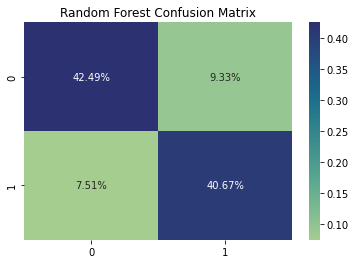

In [ ]:
RFTree_cm = confusion_matrix(y_test, RFTree_pred)
sns.heatmap(RFTree_cm/np.sum(RFTree_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("Random Forest Confusion Matrix")

#5. Support Vector Machine Classifier

In [173]:
from sklearn.svm import SVC

SVM = SVC(C = 1, gamma = 1, kernel = 'rbf')
SVM.fit(X_train, y_train)
SVM_pred = SVM.predict(X_test)
SVM_acc = accuracy_score(y_test, SVM_pred)
SVM_precision = precision_score(y_test, SVM_pred) 
SVM_recall = recall_score(y_test, SVM_pred) 
SVM_f1 = f1_score(y_test, SVM_pred)

In [ ]:
print("The accuracy for SVM is", SVM_acc)
print("The classification report using SVM is:", SVM_acc)
print(classification_report(y_test, SVM_pred))

The accuracy for SVM is 0.8354922279792746
The classification report using SVM is: 0.8354922279792746
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       400
           1       0.88      0.76      0.82       372

    accuracy                           0.84       772
   macro avg       0.84      0.83      0.83       772
weighted avg       0.84      0.84      0.83       772



Text(0.5, 1.0, 'SVM Confusion Matrix')

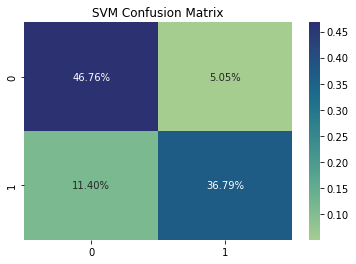

In [ ]:
SVM_cm = confusion_matrix(y_test, SVM_pred)
sns.heatmap(SVM_cm/np.sum(SVM_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("SVM Confusion Matrix")

#6. XGBoost Classifier

In [174]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators = 800, learning_rate = 0.5)
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)
XGB_acc = accuracy_score(y_test, XGB_pred)
XGB_precision = precision_score(y_test, XGB_pred)
XGB_recall = recall_score(y_test, XGB_pred)
XGB_f1 = f1_score(y_test, XGB_pred)

In [ ]:
print("The accuracy for XGBoost is", XGB_acc)
print("The classification report using XGBoost is:", XGB_acc)
print(classification_report(y_test, XGB_pred))

The accuracy for XGBoost is 0.8018134715025906
The classification report using XGBoost is: 0.8018134715025906
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       400
           1       0.76      0.85      0.81       372

    accuracy                           0.80       772
   macro avg       0.81      0.80      0.80       772
weighted avg       0.81      0.80      0.80       772



Text(0.5, 1.0, 'XGBoost Confusion Matrix')

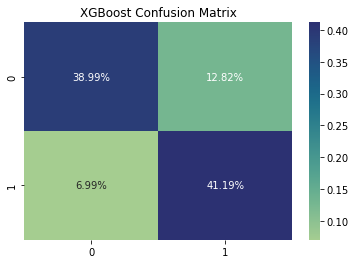

In [ ]:
XGB_cm = confusion_matrix(y_test, XGB_pred)
sns.heatmap(XGB_cm/np.sum(XGB_cm), annot = True, fmt = '0.2%', cmap = 'crest')
plt.title("XGBoost Confusion Matrix")

#Comparing Models:

In [175]:
models = pd.DataFrame({
    'Model':['Logistic Regression', 'KNN Regression', 'Decision Tree', 'Random Forest', 'Support Vector', 'XGBoost'],
    'Accuracy' :[LogReg_acc, KNN_acc, DecTree_acc, RFTree_acc, SVM_acc, XGB_acc],
    'Precision' :[LogReg_precision, KNN_precision, DecTree_precision, RFTree_precision, SVM_precision, XGB_precision],
    'Recall' :[LogReg_recall, KNN_recall, DecTree_recall, RFTree_recall, SVM_recall, XGB_recall],
    'F1 Score' :[LogReg_f1, KNN_f1, DecTree_f1, RFTree_f1, SVM_f1, XGB_f1]
})
models = models.sort_values(by='Accuracy', ascending=False)

In [176]:
models

,Model,Accuracy,Precision,Recall,F1 Score
4,Support Vector,0.835492,0.879257,0.763441,0.817266
3,Random Forest,0.831606,0.813472,0.844086,0.828496
5,XGBoost,0.801813,0.762590,0.854839,0.806084
1,KNN Regression,0.774611,0.725000,0.857527,0.785714
2,Decision Tree,0.766839,0.722222,0.838710,0.776119
0,Logistic Regression,0.467617,0.455581,0.537634,0.493218


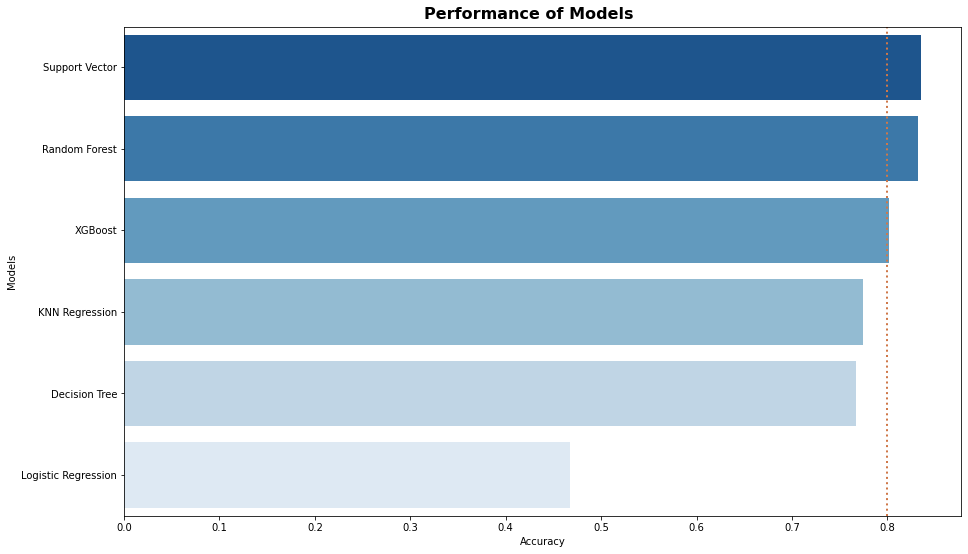

In [177]:
fig = plt.figure(figsize=(15,9))

ax = sns.barplot(data=models, 
                 y='Model', 
                 x='Accuracy',
                 palette = 'Blues_r')

ax.figure.suptitle('Performance of Models',y=0.91, size = 16, color = 'black', weight='bold');

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.axvline(x = 0.8, ymin = 0, ymax = 1,
            linewidth = 2, linestyle =":",
            color ='#cf7849');

#Post-Predictive Analysis

For comparison purposes, the original data with replaced missing values will be run through all 6 models to see the difference in performance. The dataset still has outliers and is imbalanced with regards to the amount of Non-potable samples versus potable.

In [178]:
X0 = df1.drop('Potability',axis=1)
y0 = df1['Potability']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)

scale = StandardScaler()
X0_train=scale.fit_transform(X0_train)
X0_test=scale.transform(X0_test)

In [179]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN Regression', KNeighborsClassifier(n_neighbors = 1)),
    ('Decision Tree', DecisionTreeClassifier(max_depth = 34, min_samples_leaf = 1, criterion ='entropy')),
    ('Random Forest Classifier', RandomForestClassifier(n_estimators =500, min_samples_leaf =2)),
    ('Support Vector Classifier', SVC(C = 1, gamma = 1, kernel = 'rbf')),
    ('XGB Classifier', XGBClassifier(n_estimators = 800, learning_rate = 0.5)),
]

results = dict()
for name, model in models:
    model.fit(X0_train, y0_train)
    pred = model.predict(X0_test)
        
    score = accuracy_score(y0_test, pred)    
    precision = precision_score(y0_test, pred)
    recall = recall_score(y0_test, pred)
    f1 = f1_score(y0_test, pred)                       
    results[name] = score, precision, recall, f1

In [180]:
df2 = pd.DataFrame.from_dict(results)
df2.index = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
df2

,Logistic Regression,KNN Regression,Decision Tree,Random Forest Classifier,Support Vector Classifier,XGB Classifier
Accuracy,0.628049,0.615854,0.577744,0.685976,0.617378,0.658537
Precision,0.000000,0.483051,0.441281,0.653226,0.425532,0.548544
Recall,0.000000,0.467213,0.508197,0.331967,0.081967,0.463115
F1 Score,0.000000,0.475000,0.472381,0.440217,0.137457,0.502222
